In [1]:
# Module importing and config

import os
import sys
import requests
import io
import time
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from exp import DATA_DIR

pd.set_option('display.width', 160)

In [2]:
# Global constant declaration

API_URL = "https://www.alphavantage.co/query"
API_KEY = os.environ['AV_KEY']
CONST_CSV = os.path.join(DATA_DIR, 'constituents.csv')
SP500_PKL = os.path.join(DATA_DIR, 'sp500.pkl')
WAIT_TIME = 61.
QPM = 5

data = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": "MSFT",
    "outputsize": "full",
    "datatype": "csv",
    "apikey": API_KEY,
    }

In [3]:
# Sample AV API query

run_time = timer()
response = requests.get(API_URL, data)
run_time = timer() - run_time
print(f'Response: {response}, took: {run_time:.3f} s.')

Response: <Response [200]>, took: 7.312 s.


              open    high     low   close  adjusted_close    volume  dividend_amount  split_coefficient
timestamp                                                                                               
2019-06-24  137.00  138.39  137.02  137.84          137.84  12549142              0.0                1.0
2019-06-21  136.58  137.73  136.46  136.97          136.97  36155121              0.0                1.0
2019-06-20  137.45  137.66  135.72  136.95          136.95  33042592              0.0                1.0
2019-06-19  135.00  135.93  133.81  135.69          135.69  23744441              0.0                1.0
2019-06-18  134.19  135.24  133.57  135.16          135.16  25934458              0.0                1.0
Price DF shape: (5403, 8)


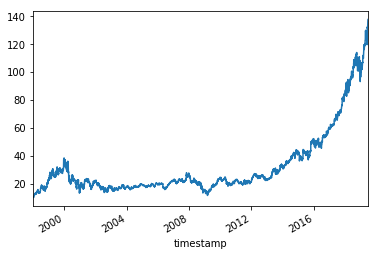

In [4]:
# Sample parsing of AV API request into pd DF of historical prices. 

file = io.StringIO(response.text)
price_df = pd.read_csv(file, index_col=0, parse_dates=['timestamp'])
print(price_df.head())
print(f'Price DF shape: {price_df.shape}')
price_df['adjusted_close'].plot()

In [5]:
# Load the reference (full) list of stock symbols that we wish to use for backtesting. 
# Load from a git versionned file to avoid remote changes affecting this set.
# Current source was taken from the page: https://datahub.io/core/s-and-p-500-companies

const_df = pd.read_csv(CONST_CSV)
print(const_df.head())
print(f'S&P 500 constituents DF shape: {const_df.shape}')

  Symbol                 Name                  Sector
0    MMM           3M Company             Industrials
1    AOS      A.O. Smith Corp             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV          AbbVie Inc.             Health Care
4    ACN        Accenture plc  Information Technology
S&P 500 constituents DF shape: (505, 3)


In [ ]:
# Complete the data necessary for backtesting, e.g.:
# - load currently pickled dict of historical prices DFs, 
# - see which symbols from the reference list above are missing, 
# - query historical prices for theses, 
# - parse them to DFs and add them to the dict of historical prices DFs, 
# - update the saved pickle.

symbols = const_df['Symbol']
if os.path.isfile(SP500_PKL):
    with open(SP500_PKL, 'rb') as file:
        prices = pickle.load(file)
else:
    prices = {}
missing_symbols = set(symbols).difference(set(prices.keys()))
tot_time = 0.
print(f'Querying AV API for {len(missing_symbols)} symbols historical prices:\n')
for i, symbol in enumerate(missing_symbols):
    if i%QPM == 0 and i>0:
        wait_time_left = WAIT_TIME - tot_time
        print(f'API quota reached, waiting {wait_time_left:.2f} s...')
        sys.stdout.flush()
        time.sleep(wait_time_left)
        tot_time = 0.
    run_time = timer()
    av_query = data.copy()
    av_query['symbol'] = symbol
    response = requests.get(API_URL, data)
    file = io.StringIO(response.text)
    try:
        price_df = pd.read_csv(file, index_col=0, parse_dates=['timestamp'])
        prices[symbol] = price_df
        run_time = timer() - run_time
        print(f'{i:03d} - Querying data for {symbol}, time={run_time:.2f} s.')
    except ValueError:
        run_time = timer() - run_time
        print(f'{i:03d} - ERROR - Querying data for {symbol} did not contain a valid DF, time={run_time:.2f} s.')
    sys.stdout.flush()
    tot_time += run_time
with open(SP500_PKL, 'wb') as file:
    pickle.dump(prices, file)
print(f'\nDict of price DFs saved as {SP500_PKL}')

Querying AV API for 82 symbols historical prices:

000 - Querying data for TSS, time=6.90 s.
001 - Querying data for VLO, time=6.59 s.
002 - Querying data for SNPS, time=7.15 s.
003 - Querying data for XLNX, time=6.91 s.
004 - Querying data for TIF, time=7.27 s.
API quota reached, waiting 26.17 s...
005 - Querying data for TSCO, time=6.77 s.
006 - Querying data for WRK, time=7.17 s.
007 - Querying data for WAT, time=6.69 s.
008 - Querying data for VNO, time=7.03 s.
009 - Querying data for WBA, time=7.26 s.
API quota reached, waiting 26.09 s...
010 - Querying data for TRIP, time=6.59 s.
011 - Querying data for ZTS, time=6.76 s.
012 - Querying data for FOXA, time=7.00 s.
013 - Querying data for VMC, time=7.01 s.
014 - Querying data for UNP, time=7.46 s.
API quota reached, waiting 26.18 s...
015 - Querying data for WM, time=6.65 s.
016 - Querying data for TMK, time=6.87 s.
017 - Querying data for WYN, time=7.02 s.
018 - Querying data for TROW, time=7.12 s.
019 - Querying data for WFC, tim

In [38]:
# Load currently pickled dict of historical prices DFs

with open(SP500_PKL, 'rb') as file:
    prices = pickle.load(file)
print(f'\nLoaded pickled prices DF dict with {len(prices)} keys:')
print(sorted(prices.keys()))


Loaded pickled prices DF dict with 423 keys:
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC', 'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX', 'BBT', 'BBY', 'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BKNG', 'BLK', 'BLL', 'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CBS', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COL', 'COP', 'COST', 'COTY', 'CPB', 'CRM', 'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DE', 'DFS', 'DG', 'DGX', 'D